In [1]:
using PerlaTonettiWaugh, Parameters, Plots, DataFrames, Optim

┌ Info: Precompiling PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1273


## New Calculations

#### Experiment 1: Consumption Equivalent Between Planners with Varying Trade Costs

In [2]:
d_0 = 3.0426
d_baseline = d_0 
d_T =  2.83834
d_lower = d_T

2.83834

In [4]:
# solve the CE for each d to obtain the [Omega, z_hat]
params = parameter_defaults(γ = 1)
settings = settings_defaults();

params_baseline = merge(params, (d = d_baseline,))
CE_baseline = stationary_numerical(params_baseline, settings)

params_lower = merge(params, (d = d_lower,))
CE_lower = stationary_numerical(params_lower, settings);

# solve the (univariate) planner's problem in each case, using [Omega, z_hat] from the appropriate CE
# use the CE g as the initial condition
welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar

planner_baseline = optimize(x -> welfare_objective([x, CE_baseline.z_hat, CE_baseline.Ω], params = params_baseline), CE_baseline.g, 0.16)
planner_baseline.converged || error("Solver didn't converge")

planner_lower = optimize(x -> welfare_objective([x, CE_lower.z_hat, CE_lower.Ω], params = params_lower), CE_lower.g, 0.16)
planner_lower.converged || error("Solver didn't converge")

In [19]:
U_bar_baseline = -minimum(planner_baseline)
U_bar_lower = -minimum(planner_lower)

PerlaTonettiWaugh.consumption_equivalent(U_bar_baseline, U_bar_lower, params)

PerlaTonettiWaugh.consumption_equivalent(U_bar_baseline, U_bar_lower, params) = 0.6690547469725042


0.6690547469725042

#### Experiment 2: Consumption Equivalent Between Planner and CE with Baseline Trade Costs

In [22]:
d_0 = 3.0426
d_baseline = d_0 

3.0426

In [21]:
params = parameter_defaults(γ = 1)
settings = settings_defaults();

params_baseline = merge(params, (d = d_baseline,))
CE_baseline = stationary_numerical(params_baseline, settings)
U_bar_CE = CE_baseline.U_bar 

welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar
planner_baseline = optimize(x -> welfare_objective([x, CE_baseline.z_hat, CE_baseline.Ω], params = params_baseline), CE_baseline.g, 0.16)
planner_baseline.converged || error("Solver didn't converge")
U_bar_planner = -minimum(planner_baseline)

PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_CE, params)

PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_CE, params) = 82.31248982525722


82.31248982525722

#### Experiment 3: Consumption Equivalent Between Planner and CE with Lower Trade Costs

In [23]:
d_T =  2.83834
d_lower = d_T

2.83834

In [24]:
params = parameter_defaults(γ = 1)
settings = settings_defaults();

params_lower = merge(params, (d = d_lower,))
CE_lower = stationary_numerical(params_lower, settings)
U_bar_CE = CE_lower.U_bar 

welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar
planner_lower = optimize(x -> welfare_objective([x, CE_lower.z_hat, CE_lower.Ω], params = params_lower), CE_lower.g, 0.16)
planner_lower.converged || error("Solver didn't converge")
U_bar_planner = -minimum(planner_lower)

PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_CE, params) 

PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_CE, params) = 114.06785030976911


114.06785030976911

#### Experiment 4: Consumption Equivalent Between CEs with Varying Trade Costs

In [25]:
d_0 = 3.0426
d_baseline = d_0 
d_T =  2.83834
d_lower = d_T

2.83834

In [26]:
# solve the CE for each d to obtain the [Omega, z_hat]
params = parameter_defaults(γ = 1)
settings = settings_defaults();

params_baseline = merge(params, (d = d_baseline,))
CE_baseline = stationary_numerical(params_baseline, settings)

params_lower = merge(params, (d = d_lower,))
CE_lower = stationary_numerical(params_lower, settings);

In [30]:
PerlaTonettiWaugh.consumption_equivalent(CE_lower.U_bar, CE_baseline.U_bar, params) # baseline is "U_old"

1.0785513461328116

## Old Calculations

In [2]:
params_base = parameter_defaults()
d_0 = params_base.d_0
d_T = params_base.d_T
settings = settings_defaults();

In [3]:
welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar

welfare_objective (generic function with 1 method)

In [4]:
df = DataFrame()
d_grid = range(d_0, d_T, length = 100) # we see instability around d_0 

for d in d_grid
    params = merge(params_base, (d = d,))

    sol_competitive = stationary_numerical(params, settings)
    init_x = [sol_competitive.g, sol_competitive.z_hat, sol_competitive.Ω]

    sol_planner = try optimize(x -> welfare_objective([x, sol_competitive.z_hat, sol_competitive.Ω], params = params), 0.005, 0.16)
    catch e 
        continue # just skip it if it doesn't work
    end
    
    g_planner = Optim.minimizer(sol_planner)
    U_bar_planner = -Optim.minimum(sol_planner)
    U_bar_competitive = sol_competitive.U_bar
    
    consumption_equivalent = PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_competitive, params)
    
    push!(df, (d = d,
                g_rat = g_planner/sol_competitive.g, 
                g_planner = g_planner,
                g_competitive = sol_competitive.g,
                consumption_equivalent = consumption_equivalent,
                U_bar_planner = U_bar_planner,
                U_bar_competitive = U_bar_competitive,
                U_bar_rat = U_bar_planner/sol_competitive.U_bar,
            ))
end

size(df) # check for emptiness

(100, 8)

In [5]:
p_g_ratio = plot(df.d, df.g_rat, xlabel = "d", ylabel = "g ratio", title = "growth rates ratio (planner/competitive)", legend = false);
p_g_levels = plot(xlabel = "d", ylabel = "g", title = "growth rate levels", legend = :topleft)
plot!(p_g_levels, df.d, df.g_competitive, label = "competitive eq.")
plot!(p_g_levels, df.d, df.g_planner, label = "planner");

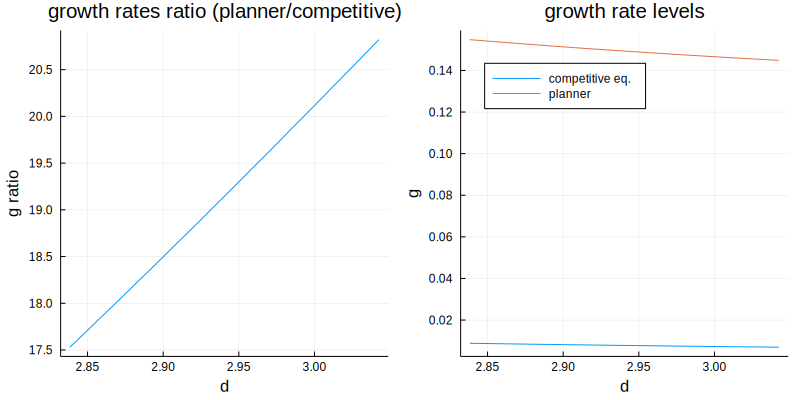

In [6]:
plot(p_g_ratio, p_g_levels,size = (800, 400))

In [7]:
p_consumption_equivalent = plot(df.d, df.consumption_equivalent, xlabel = "d", title = "Consumption Equivalent", legend = false)
p_welfare_ratio = plot(df.d, df.U_bar_rat, xlabel = "d", ylabel = "U_bar ratio", title = "Welfare ratio (planner/equilibrium)", legend = false);

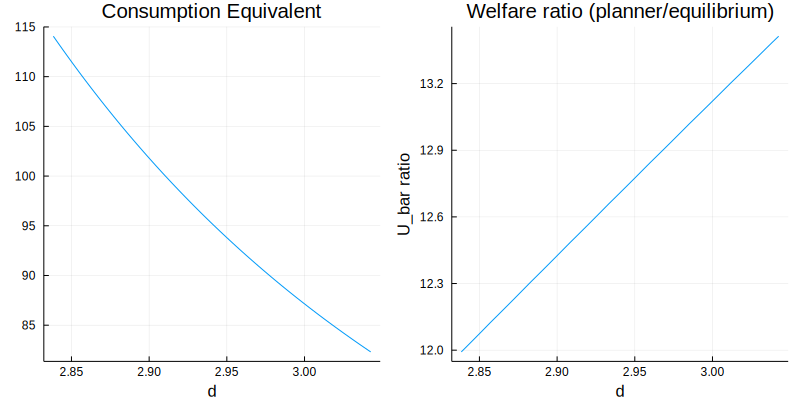

In [8]:
plot(p_consumption_equivalent, p_welfare_ratio, size = (800, 400))

## $\gamma$ = 2 Experiments

In [10]:
params_base = parameter_defaults(γ = 2, χ = 0.1895)
d_0 = params_base.d_0
d_T = params_base.d_T
settings = settings_defaults();

In [11]:
welfare_objective(vals; params) = -PerlaTonettiWaugh.welfare(vals, params).U_bar

welfare_objective (generic function with 1 method)

In [12]:
df = DataFrame()
d_grid = range(d_0, d_T, length = 100) # we see instability around d_0 

for d in d_grid
    params = merge(params_base, (d = d,))

    sol_competitive = stationary_numerical(params, settings)
    init_x = [sol_competitive.g, sol_competitive.z_hat, sol_competitive.Ω]

    sol_planner = try optimize(x -> welfare_objective([x, sol_competitive.z_hat, sol_competitive.Ω], params = params), 0.005, 0.16)
    catch e 
        continue # just skip it if it doesn't work
    end
    
    g_planner = Optim.minimizer(sol_planner)
    U_bar_planner = -Optim.minimum(sol_planner)
    U_bar_competitive = sol_competitive.U_bar
    
    consumption_equivalent = PerlaTonettiWaugh.consumption_equivalent(U_bar_planner, U_bar_competitive, params)
    
    push!(df, (d = d,
                g_rat = g_planner/sol_competitive.g, 
                g_planner = g_planner,
                g_competitive = sol_competitive.g,
                consumption_equivalent = consumption_equivalent,
                U_bar_planner = U_bar_planner,
                U_bar_competitive = U_bar_competitive,
                U_bar_rat = U_bar_planner/sol_competitive.U_bar,
            ))
end

size(df) # check for emptiness

(100, 8)

In [13]:
p_g_ratio = plot(df.d, df.g_rat, xlabel = "d", ylabel = "g ratio", title = "growth rates ratio (planner/competitive)", legend = false);
p_g_levels = plot(xlabel = "d", ylabel = "g", title = "growth rate levels", legend = :right)
plot!(p_g_levels, df.d, df.g_competitive, label = "competitive eq.")
plot!(p_g_levels, df.d, df.g_planner, label = "planner");

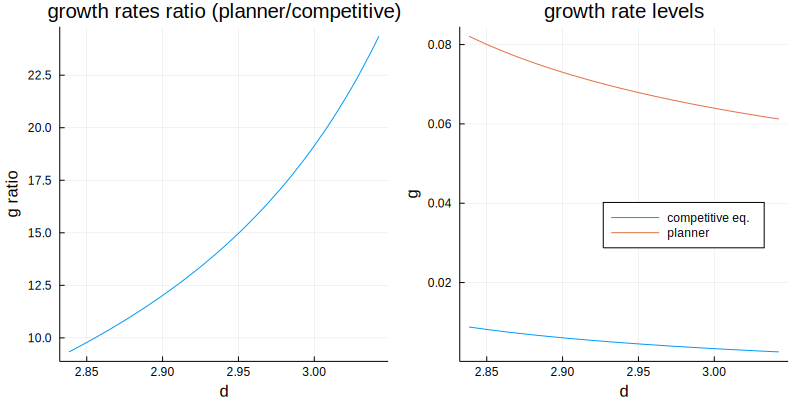

In [14]:
plot(p_g_ratio, p_g_levels,size = (800, 400))

In [15]:
p_consumption_equivalent = plot(df.d, df.consumption_equivalent, xlabel = "d", title = "Consumption Equivalent", legend = false)
p_welfare_ratio = plot(xlabel = "d", ylabel = "U_bar", title = "Welfare Levels", legend = :right)
plot!(p_welfare_ratio, df.U_bar_competitive, label = "Competitive")
plot!(p_welfare_ratio, df.U_bar_planner, label = "Planner");

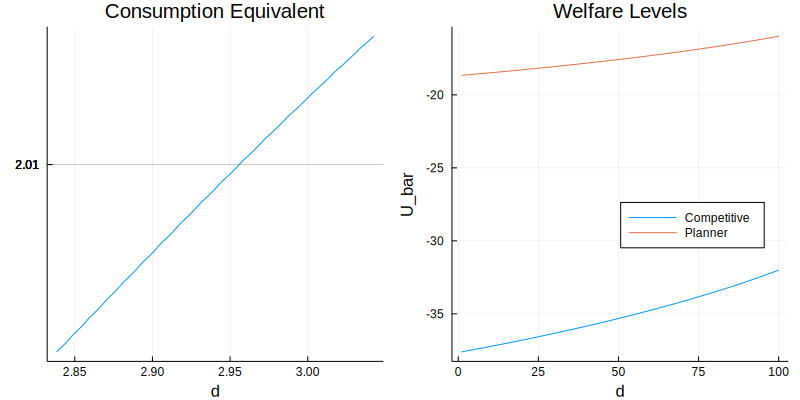

In [16]:
plot(p_consumption_equivalent, p_welfare_ratio, size = (800, 400))